<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Analysis</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li>

# Recovery of gold from ore

Preparation of a prototype machine learning model for the company that develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore. We will use data with extraction and purification parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

Tasks:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

## Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
data_train = pd.read_csv('gold_recovery_train_new.csv')
data_test = pd.read_csv('gold_recovery_test_new.csv')
data_full = pd.read_csv('gold_recovery_full_new.csv')

In [ ]:
#Fill in the gaps in the training data
data_train = data_train.fillna(value=None, method='ffill')

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14149 non-null  float64
 8   final.output.tail_sol                               14149 non-null  float64


In [ ]:
#Check the correctness of the enrichment efficiency calculation
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
counted_recovery = (C*(F-T))/(F*(C-T))*100

In [ ]:
print('MAE value: {}'.format(mean_absolute_error(data_train['rougher.output.recovery'], counted_recovery)))

MAE value: 9.73512347450521e-15


The MAE value is very small and corresponds to the measurement error of enrichment efficiency. We conclude that the calculation of the efficiency of enrichment of raw materials after flotation is correct.

In [ ]:
#Fill in the gaps in the test data
data_test = data_test.fillna(value=None, method='ffill')

In [ ]:
#Check the missing features in the test sample
data_train[data_train.columns[~data_train.columns.isin(data_test)]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


The missing parameters are of the float type and are calculated based on the results of each stage of ore processing.

In the test sample, some calculated (calculation) and output (output) characteristics of the process are not available because they cannot be obtained or measured during the execution of the technological process.

## Data Analysis

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14149 non-null  float64
 8   final.output.tail_sol                               14149 non-null  float64


In [ ]:
#Check the concentration of metals at various stages of purification
concentrate_au_dynamics=data_train[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
'final.output.concentrate_au']]
concentrate_ag_dynamics=data_train[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
'final.output.concentrate_ag']]
concentrate_pb_dynamics=data_train[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb',
'final.output.concentrate_pb']]

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np

y_cum_sum = [concentrate_au_dynamics['rougher.output.concentrate_au'].sum(),
             concentrate_au_dynamics['primary_cleaner.output.concentrate_au'].sum(),
             concentrate_au_dynamics['final.output.concentrate_au'].sum()
            ]
y_mean = [concentrate_au_dynamics['rougher.output.concentrate_au'].mean(),
             concentrate_au_dynamics['primary_cleaner.output.concentrate_au'].mean(),
             concentrate_au_dynamics['final.output.concentrate_au'].mean()]

x = concentrate_au_dynamics.columns


#Creating two subplots
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(
    x=y_cum_sum,
    y=x,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Cummulative sum of AU concentration per step, %',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=y_mean, y=x,
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='Mean AU concentrate per step, %',
), 1, 2)

fig.update_layout(
    title='AU concentrate dynamics per step of production',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_cum_sum, decimals=2)
y_nw = np.rint(y_mean)

#Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x):
    #labeling the scatter mean concentrate
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn,
                            text='{:,}'.format(ydn) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    #labeling the bar accumulated sum
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd,
                            text=str(yd),
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

The dashboard shows that as the raw material is refined, the concentration of gold increases.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np

y_cum_sum = [concentrate_ag_dynamics['rougher.output.concentrate_ag'].sum(),
             concentrate_ag_dynamics['primary_cleaner.output.concentrate_ag'].sum(),
             concentrate_ag_dynamics['final.output.concentrate_ag'].sum()
            ]
y_mean = [concentrate_ag_dynamics['rougher.output.concentrate_ag'].mean(),
             concentrate_ag_dynamics['primary_cleaner.output.concentrate_ag'].mean(),
             concentrate_ag_dynamics['final.output.concentrate_ag'].mean()]

x = concentrate_ag_dynamics.columns


#Creating two subplots
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(
    x=y_cum_sum,
    y=x,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Cummulative sum of AG concentration per step, %',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=y_mean, y=x,
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='Mean AG concentrate per step, %',
), 1, 2)

fig.update_layout(
    title='AG concentrate dynamics per step of production',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_cum_sum, decimals=2)
y_nw = np.rint(y_mean)

#Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x):
    #labeling the scatter mean concentrate
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn,
                            text='{:,}'.format(ydn) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    #labeling the bar accumulated sum
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd,
                            text=str(yd),
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

The concentration of silver decreases as the raw material is purified from impurities.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np

y_cum_sum = [concentrate_pb_dynamics['rougher.output.concentrate_pb'].sum(),
             concentrate_pb_dynamics['primary_cleaner.output.concentrate_pb'].sum(),
             concentrate_pb_dynamics['final.output.concentrate_pb'].sum()
            ]
y_mean = [concentrate_pb_dynamics['rougher.output.concentrate_pb'].mean(),
             concentrate_pb_dynamics['primary_cleaner.output.concentrate_pb'].mean(),
             concentrate_pb_dynamics['final.output.concentrate_pb'].mean()]

x = concentrate_pb_dynamics.columns


#Creating two subplots
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(
    x=y_cum_sum,
    y=x,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Cummulative sum of PB concentration per step, %',
    orientation='h',
), 1, 1)

fig.append_trace(go.Scatter(
    x=y_mean, y=x,
    mode='lines+markers',
    line_color='rgb(128, 0, 128)',
    name='Mean PB concentrate per step, %',
), 1, 2)

fig.update_layout(
    title='PB concentrate dynamics per step of production',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_cum_sum, decimals=2)
y_nw = np.rint(y_mean)

#Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x):
    #labeling the scatter mean concentrate
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn,
                            text='{:,}'.format(ydn) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    #labeling the bar accumulated sum
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd,
                            text=str(yd) ,
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

The concentration of the metal increases during purification at the stage of primary purification, but remains practically unchanged after the secondary purification of raw materials.

Text(0.5, 1.0, 'Rougher.input.feed_size')

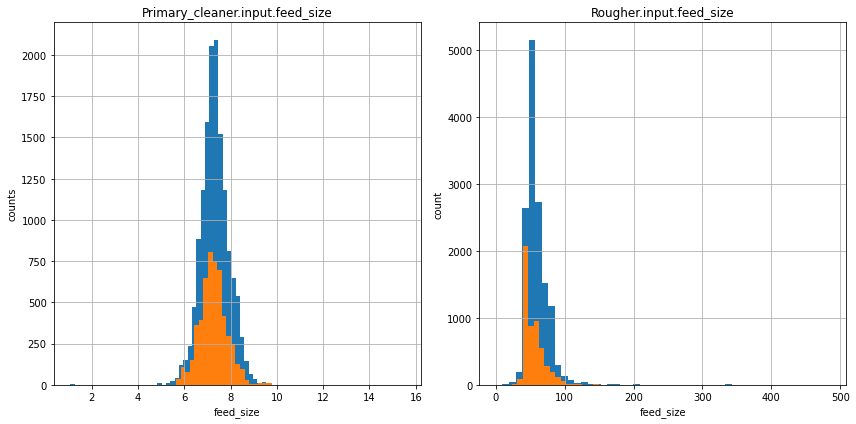

In [ ]:
#Comparison of the size distribution of raw material granules on the training and test samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax1.set_ylabel('counts')
ax1.set_xlabel('feed_size')
ax1.hist(data_train['primary_cleaner.input.feed_size'], bins=50)
ax1.hist(data_test['primary_cleaner.input.feed_size'], bins=50)
ax1.grid(True)
ax1.set_title('Primary_cleaner.input.feed_size')

ax2.set_xlabel('feed_size')
ax2.set_ylabel('count')
ax2.hist(data_train['rougher.input.feed_size'], bins=50)
ax2.hist(data_test['rougher.input.feed_size'], bins=50)
ax2.grid(True)
ax2.set_title('Rougher.input.feed_size')


The distribution for the test sample is slightly different from that for the training sample - the first one is slightly shifted down. But in general, the sizes of most particles lie in the optimal range of 40–100 µm (“Flotation of the ore”: Tekhnoanalitpribor LLC: [website]. URL: https://techade.ru/stati/flotatsiya-rudy) for both samples. So yes, the samples are eligible for evaluation.

In [ ]:
#total concentration of all substances at different stages
data_train['rougher.output.concentrate_total'] = data_train['rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_sol']  
            
data_train['rougher.input.feed_total'] = data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_au']+data_train['rougher.input.feed_sol'] 

data_train['final.output.concentrate_total'] = data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_au']+data_train['final.output.concentrate_sol']  

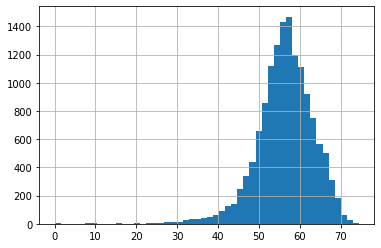

In [ ]:
data_train['rougher.input.feed_total'].hist(bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f31e76b7810>,
 'caps': [<matplotlib.lines.Line2D at 0x7f31e7662150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f31e7773350>],
 'medians': [<matplotlib.lines.Line2D at 0x7f31e47d7510>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f31e4c6b350>],
 'means': []}

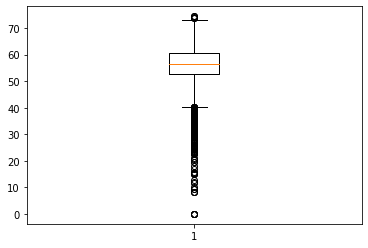

In [ ]:
plt.boxplot(data_train['rougher.input.feed_total'])

In [ ]:
data_train = data_train[data_train['rougher.input.feed_total'] != 0]

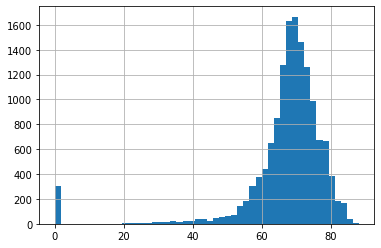

In [ ]:
data_train['rougher.output.concentrate_total'].hist(bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f31e460dd10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f31e46137d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f31e45f1450>],
 'medians': [<matplotlib.lines.Line2D at 0x7f31e459b2d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f31e459b810>],
 'means': []}

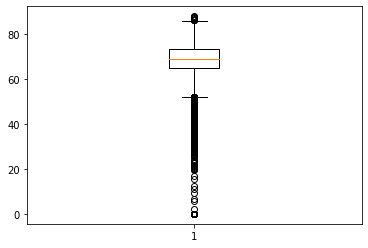

In [ ]:
plt.boxplot(data_train['rougher.output.concentrate_total'])

In [ ]:
data_train = data_train[data_train['rougher.output.concentrate_total'] != 0]

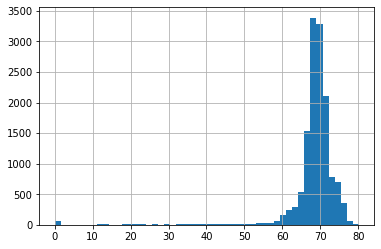

In [ ]:
data_train['final.output.concentrate_total'].hist(bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f31e448bf10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f31e44909d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f31e446f690>],
 'medians': [<matplotlib.lines.Line2D at 0x7f31e44184d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f31e4418a10>],
 'means': []}

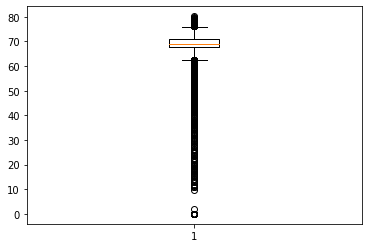

In [ ]:
plt.boxplot(data_train['final.output.concentrate_total'])

In [ ]:
data_train = data_train[data_train['final.output.concentrate_total'] != 0]

At the stage of raw materials, the distribution of the concentration of substances is in the range from 40% to 70%. At the stage of crude concentrate, the total concentration of all substances is shifted to the right in the range from 50% to 85%. At the stage of the final concentrate, the total concentration of all substances goes into the range from 65% to 75%.

There are zero anomalies in total concentrations - and it is better to "kill" them. The fact is that at least a gram of something is in the "total ore" - salt + gold + silver + lead - there must definitely be something .. And if we have zero, then there is a high probability of inaccurate measurements.

## Модель

In [ ]:
#Let's highlight the influencing factors and resulting indicators
X_columns  = data_test.drop(columns=['date',
                                     'rougher.input.feed_ag', 
                                     'rougher.input.feed_pb',
                                     'rougher.input.feed_sol']).columns

In [ ]:
Y_columns = ['rougher.output.recovery', 'final.output.recovery']

In [ ]:
#Resulting function
def sMAPE(target_test, predictions):
    rougher, final  = (abs(target_test - predictions)/((abs(target_test) + abs(predictions)) /2)).mean() * 100
    result = (0.25*rougher + 0.75*final)
    return result

smape = make_scorer(sMAPE)

#Split the data into training and test features and targets
X_train = data_train[X_columns]
Y_train = data_train[Y_columns]
X_test = data_test[X_columns]
Y_test = data_full[data_full['date'].isin(data_test['date'])][Y_columns].reset_index(drop=True)

#Factors normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Description of the model and hyperparameters
model_lr = LinearRegression()
params_lr = {
    'fit_intercept':[True, False],
    'copy_X':[True, False],
    'n_jobs':[None, -1]
}

model_forest = RandomForestRegressor(random_state=0)
params_forest = {
    'max_depth':np.array(range(1,10)),
    'n_estimators':np.array(range(1,10))
}

model_tree = DecisionTreeRegressor(random_state=0)
params_tree = {
    'max_depth':np.array(range(1,10)),
    'min_samples_split':np.array(range(2,10))
}

models = [model_lr, model_forest, model_tree]
params = [params_lr, params_forest, params_tree]

#Cross-validation for model checking
for i, j in zip(models, params):
    

    search = GridSearchCV(estimator=i,
                         param_grid=j,
                         scoring=smape,
                         cv = 3)

    result = search.fit(X_train_scaled, Y_train)

    print('Model tested: %s' % i)
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

Model tested: LinearRegression()
Best Score: 180.98445150813168
Best Hyperparameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': None}
Model tested: RandomForestRegressor(random_state=0)
Best Score: 12.603258682763611
Best Hyperparameters: {'max_depth': 9, 'n_estimators': 1}
Model tested: DecisionTreeRegressor(random_state=0)
Best Score: 14.328919704764557
Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 3}


Thus, the smallest smape value is shown by the RandomForestRegressor model. Let's test it on a test sample.

In [ ]:
model = RandomForestRegressor(random_state=0, max_depth=9, n_estimators=1)
model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)
print('Final value sMAPE: {:.2f}%'.format(sMAPE(Y_test, predictions)))

Final value sMAPE: 10.57%


The value of the resulting metric on the test sample turned out to be 10.57%, which is a fairly representative value for the model.

The metric is quite low. And that's good.<br>
We need to understand that our model predicts better than just the average.<br>
For example, substitute the median values ​​of the target train into the predictive metric formula. <br>
Or use DummyRegression.

In [ ]:
Y_train_rougher = Y_train['rougher.output.recovery']
Y_train_final = Y_train['final.output.recovery']

In [ ]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="median")

dummy_regressor.fit(X_train_scaled, Y_train_rougher)
dummy_rougher_pred = dummy_regressor.predict(X_test)

dummy_regressor.fit(X_train_scaled, Y_train_final)
dummy_final_pred = dummy_regressor.predict(X_test)

dummy_pred = np.column_stack([dummy_rougher_pred, dummy_final_pred])

smape_dummy = sMAPE(Y_test, dummy_pred)
print('sMAPE: {:.2f}%'.format(smape_dummy))
 

sMAPE: 9.44%


Comparison with the constant model showed that the sMAPE metric on the constant model is slightly lower than on the predicted values ​​of the random forest model, so it is rather difficult to talk about the adequacy of the predictions made by the model.